In [1]:
from keras.models import load_model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, Reshape, Flatten,Dropout
from keras.models import Model
from keras.models import load_model
import random
from tensorflow.keras.utils import plot_model
import pydot
import graphviz
import shap
import tensorflow as tf
tf.compat.v1.enable_v2_behavior()

In [2]:
model=load_model("combined_model_lstm_encoder_10.h5")

In [3]:
model_cnn=load_model("Cnn_lstm_model_10.h5")

In [4]:
test=np.load("test_data.npy",allow_pickle=True)

In [5]:
minmax=np.load("min_max.npy")

In [6]:
feature_names=("IC","ID","VC","VD","TC","TD")

In [7]:
X2=np.load("X2_10.npy")

In [8]:
def normalization(x,min_max):
    t=np.zeros((len(x),6,500))
    for i in range(len(x)):
        x["Ic"][i]= (x["Ic"][i]-min_max[0])/(min_max[1]-min_max[0])
        x["Id"][i]= (x["Id"][i]-min_max[2])/(min_max[3]-min_max[2])
        x["Vc"][i]= (x["Vc"][i]-min_max[4])/(min_max[5]-min_max[4])
        x["Vd"][i]= (x["Vd"][i]-min_max[6])/(min_max[7]-min_max[6])
        x["Tc"][i]= (x["Tc"][i]-min_max[8])/(min_max[9]-min_max[8])
        x["Td"][i]= (x["Td"][i]-min_max[10])/(min_max[11]-min_max[10])
        t[i][0][0:len(x["Ic"][i])]=x["Ic"][i]
        t[i][1][0:len(x["Id"][i])]=x["Id"][i]
        
        t[i][2][0:len(x["Vc"][i])]=x["Vc"][i]
        t[i][3][0:len(x["Vd"][i])]=x["Vd"][i]
        
        t[i][4][0:len(x["Tc"][i])]=x["Tc"][i]
        t[i][5][0:len(x["Td"][i])]=x["Td"][i]
    
    return t

In [9]:
def prepare(x):
    t=np.zeros((len(x),6,500))
    for i in range(len(x)):
        t[i][0][0:len(x["Ic"][i])]=x["Ic"][i]
        t[i][1][0:len(x["Id"][i])]=x["Id"][i]
        t[i][2][0:len(x["Vc"][i])]=x["Vc"][i]
        t[i][3][0:len(x["Vd"][i])]=x["Vd"][i]
        t[i][4][0:len(x["Tc"][i])]=x["Tc"][i]
        t[i][5][0:len(x["Td"][i])]=x["Td"][i]
    
    return t

In [10]:
def calculate_shap_values(model,X):
    M=1000
    ic=[]
    id=[]
    vc=[]
    vd=[]
    tc=[]
    td=[]
    s=[ic,id,vc,vd,tc,td]
    for i in range(M):
        z_index=random.sample(range(len(X)),1)[0]
        z = np.reshape(X[z_index-1:z_index],(10,6,500))
        for j in range(6):
            x_j=z.copy()
            #construct a sample without feature j
            for k in range(10):
                x_j[k][j]=np.random.rand(500)
            y_with_j=model.predict(np.reshape(z,(1,10,6,500)),verbose = 0)
            y_without_j=model.predict(np.reshape(x_j,(1,10,6,500)),verbose = 0)
            s[j].append(np.average(y_with_j-y_without_j))
    
    shap_values=[]
    for j in range(6):
        shap_values.append(np.average(s[j]))
    return shap_values,s

In [11]:
shap_values,values=calculate_shap_values(model,X2)


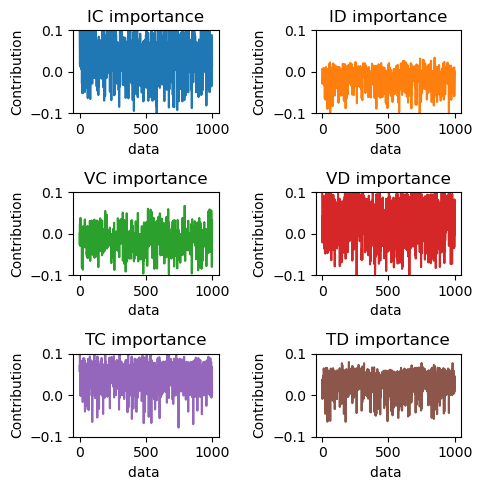

In [12]:
t = np.arange(-20, 20, 4)
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(5, 5))
axs[0, 0].set_title("IC importance")
axs[0, 0].plot(values[0], color='C0')
axs[0, 0].set_xlabel("data ")
axs[0, 0].set_ylabel("Contribution")
axs[0, 0].set_ylim([-0.1, 0.1])


axs[0, 1].set_title("ID importance")
axs[0, 1].plot(values[1], color='C1')
axs[0, 1].set_xlabel("data ")
axs[0, 1].set_ylabel("Contribution")
axs[0, 1].set_ylim([-0.1, 0.1])

axs[1, 0].set_title("VC importance")
axs[1, 0].plot(values[2], color='C2')
axs[1, 0].set_xlabel("data ")
axs[1, 0].set_ylabel("Contribution")
axs[1, 0].set_ylim([-0.1, 0.1])

axs[1, 1].set_title("VD importance")
axs[1, 1].plot(values[3], color='C3')
axs[1, 1].set_xlabel("data ")
axs[1, 1].set_ylabel("Contribution")
axs[1, 1].set_ylim([-0.1, 0.1])

axs[2, 0].set_title("TC importance")
axs[2, 0].plot(values[4], color='C4')
axs[2, 0].set_xlabel("data ")
axs[2, 0].set_ylabel("Contribution")
axs[2, 0].set_ylim([-0.1, 0.1])

axs[2, 1].set_title("TD importance")
axs[2, 1].plot(values[5], color='C5')
axs[2, 1].set_xlabel("data ")
axs[2, 1].set_ylabel("Contribution")
axs[2, 1].set_ylim([-0.1, 0.1])
fig.tight_layout()
fig.savefig("feimlstm.pdf", format="pdf", dpi=300,bbox_inches='tight')

In [13]:
t=np.argsort((shap_values))[::-1][:6]
shap_values.sort(reverse=True)

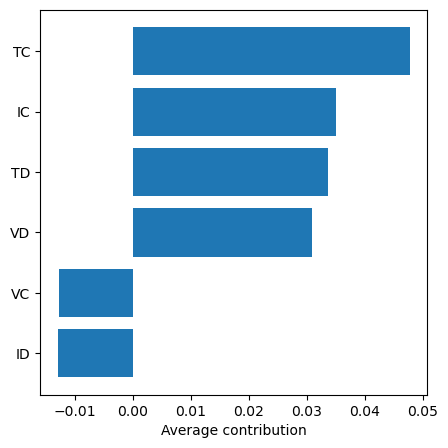

In [14]:
np.random.seed(19680801)


plt.rcdefaults()
fig, ax = plt.subplots(figsize=(5, 5))

# Example data
people = feature_names
y_pos = np.arange(6)
performance = shap_values

ax.barh(y_pos,performance, align='center')
ax.set_yticks(y_pos, labels=(feature_names[t[0]],feature_names[t[1]],feature_names[t[2]],feature_names[t[3]],feature_names[t[4]],feature_names[t[5]]))
ax.invert_yaxis()  
ax.set_xlabel('Average contribution')
fig.savefig("summarylstm.pdf", format="pdf", dpi=300,bbox_inches='tight')
plt.show()

In [15]:
def calculate_shap_values2(model,X):
    M=1000
    ic=[]
    id=[]
    vc=[]
    vd=[]
    tc=[]
    td=[]
    sg=[ic,id,vc,vd,tc,td]
    ss=[ic.copy(),id.copy(),vc.copy(),vd.copy(),tc.copy(),td.copy()]
    for i in range(M):
        for j in range(6):
            z_index=random.sample(range(len(X)),1)[0]
            z = np.reshape(X[z_index-1:z_index],(10,6,500))
            x_jg=z.copy()
            x_js=z.copy()
            for k in range(10):
                x_jg[k][j]=z[k][j]+0.5
                x_js[k][j]=z[k][j]-0.5
            y_with_j=model.predict(np.reshape(z,(1,10,6,500)),verbose = 0)
            y_without_gj=model.predict(np.reshape(x_jg,(1,10,6,500)),verbose = 0)
            y_without_sj=model.predict(np.reshape(x_js,(1,10,6,500)),verbose = 0)
            sg[j].append(np.average(y_with_j-y_without_gj))
            ss[j].append(np.average(y_with_j-y_without_sj))
    
    return ss,sg

In [16]:
values1,values2=calculate_shap_values2(model,X2)

In [17]:
avg=[]
for i in range(6):
    avg.append((np.average(values1[i]),np.average(values2[i])))

In [18]:
np.shape(avg)

(6, 2)

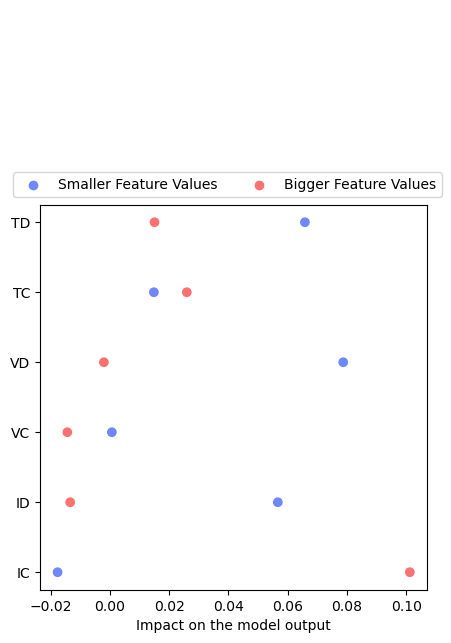

In [20]:
# Your existing code
fig, ax = plt.subplots(figsize=(5, 5))

colors = ['#7087FA', '#FA7270', '#7087FA', '#FA7270', '#7087FA', '#FA7270', '#7087FA', '#FA7270', '#7087FA', '#FA7270', '#7087FA', '#FA7270']
sc = ax.scatter(np.array(avg), ["IC", "IC", "ID", "ID", "VC", "VC", "VD", "VD", "TC", "TC", "TD", "TD"], c=colors)
ax.set_xlabel('Impact on the model output', loc='center')

# Create a separate axis for the legend
legend_ax = fig.add_axes([0.5, 0.57, 0.0, 0.7])  # Adjust the position as needed

# Plot dummy points with the same colors as the scatter plot
legend_ax.scatter([], [], c="#7087FA", label='Smaller Feature Values')
legend_ax.scatter([], [], c="#FA7270", label='Bigger Feature Values')

# Hide the axes
legend_ax.set_xticks([])
legend_ax.set_yticks([])
legend_ax.spines['top'].set_visible(False)
legend_ax.spines['bottom'].set_visible(False)
legend_ax.spines['right'].set_visible(False)
legend_ax.spines['left'].set_visible(False)

# Add legend
legend_ax.legend(loc='center',ncol=2)

# Save and show the plot
fig.savefig("fimpactlstm.pdf", format="pdf", dpi=300, bbox_inches='tight')
plt.show()